In [1]:
using POMDPs # for MDP type
using DiscreteValueIteration
using POMDPPolicies
using POMDPModelTools #for sparse cat 
using Parameters
using Random
using Plots; default(fontfamily="Computer Modern", framestyle=:box) # LaTex-style
using QuickPOMDPs
using Distributions 
#using PlotlyJS
using LinearAlgebra
using POMDPSimulators

In [2]:
Random.seed!(0xC0FFEE)

MersenneTwister(12648430)

**States**

In [3]:
# A state s in the evacuation problem is a discrete set of 4 values: 
# chairs remaining, time remaining, family size, and visa status
struct State
    c::Int # chairs remaining 
    t::Int # time remaining 
    f::Int # family size 
    v::Int # visa status 
end 

**Environment Parameters**

In [4]:
# TO DO: WEIGHT FAMILY SIZES AND VISA STATUS BY PROBABILITY 
@with_kw struct EvacuationParameters
    # could add threshold here 
    family_sizes::Vector{Int} = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # set with no repeats 
    # p_family_sizes::Vector{Float} = # must sum to 1 
    visa_status::Vector{Int} = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5] #TODO: map to various status 
    # p_visa_status::Vector{Float} = # must sum to 1 
    capacity::Int = 60
    time::Int = 60
    size::Tuple{Int, Int} = (length(visa_status), length(family_sizes)) # size of grid 
    p_transition::Real = 0.8 # don't we always transition into this since time moves forward? I'm confused... 
    null_state::State = State(-1, -1, -1 ,-1) # is there someway to do this???
end


EvacuationParameters

In [5]:
params = EvacuationParameters(); 

In [6]:
@show number_states = params.capacity * params.time * size(params.family_sizes)[1] * size(params.visa_status)[1]

number_states = params.capacity * params.time * (size(params.family_sizes))[1] * (size(params.visa_status))[1] = 420000


420000

In [7]:
# The state space S for the evacuation problem is the set of all combinations 
𝒮 = []
for c in 0:params.capacity # capacity ends at 0 
    for t in 0:params.time # time ends at 0 
        for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
            for v in params.visa_status # actual visa statuses 
                new = State(c, t, f, v) 
                𝒮 = [𝒮; new]
            end
        end        
    end
end
𝒮 = [𝒮; params.null_state]




433101-element Vector{Any}:
 State(0, 0, 1, -5)
 State(0, 0, 1, -4)
 State(0, 0, 1, -3)
 State(0, 0, 1, -2)
 State(0, 0, 1, -1)
 State(0, 0, 1, 1)
 State(0, 0, 1, 2)
 State(0, 0, 1, 3)
 State(0, 0, 1, 4)
 State(0, 0, 1, 5)
 State(0, 0, 2, -5)
 State(0, 0, 2, -4)
 State(0, 0, 2, -3)
 ⋮
 State(70, 60, 9, 5)
 State(70, 60, 10, -5)
 State(70, 60, 10, -4)
 State(70, 60, 10, -3)
 State(70, 60, 10, -2)
 State(70, 60, 10, -1)
 State(70, 60, 10, 1)
 State(70, 60, 10, 2)
 State(70, 60, 10, 3)
 State(70, 60, 10, 4)
 State(70, 60, 10, 5)
 State(-1, -1, -1, -1)

**Actions**

In [8]:
# the possible actions are whether accept or reject a family at the gate 
@enum Action REJECT ACCEPT

In [9]:
𝒜 = [REJECT, ACCEPT]

2-element Vector{Action}:
 REJECT::Action = 0
 ACCEPT::Action = 1

In [10]:
# only inbounds if room for the family [assuming would not separate even though might]
# and if time is available to enter the airport 
validtime(s::State) = 0 < s.t 

validtime (generic function with 1 method)

In [11]:
validcapacity(s::State) = 0 ≤ s.c # maybe try back to 0 

validcapacity (generic function with 1 method)

**Transition Function** 

In [12]:
function T(s::State, a::Action)
    next_states = []
    if validtime(s) 
        
        f′ = rand(params.family_sizes) # pull according to those probabilities 
        v′ = rand(params.visa_status) # TODO: possibly make this weighted in some way 
        # keep pushing to next states and have a bigger associated probability mass with those possible next states. 
        # need a for loop iterating over all family sizes and and visa statuses 
        
        if a == ACCEPT 
            next_state_accept = State(s.c - s.f, s.t - 1, f′, v′) # they get seats
            next_state_reject = State(s.c, s.t - 1, f′, v′)
            push!(next_states, next_state_accept)
            push!(next_states, next_state_reject)
            if !validcapacity(next_state_accept) 
                probabilities = [0, 1] #no room for full family :( so we make probability 0 to accept and 1 reject
            else
                probabilities = [.80, .20]
            end

        elseif a == REJECT
            probabilities = [1.0]
            push!(next_states, State(s.c, s.t - 1, f′, v′))
        end
    else
        push!(next_states,params.null_state)
        probabilities = [1]
    end
    return SparseCat(next_states, probabilities)
end

# returning dis over all possible next states ... can ignore the ones that are zero or not feasible 
# you want that distribution to sampled 
# Include additional next states, with some probability mass -> assign that probability mass to 
# allows us to include the certainty to transition to the next state and allow whoever using it to know that
# we want to return a distribution that can then be used. 
# include weighting of how we wieght -> keep adding and making sure probability vector sums to 1 and 
# every single possble state has a probability associated with it. 
    

T (generic function with 1 method)

**Reward Function**

In [13]:
function R(s::State, a::Action)
    # reward is just the visa status times family size i think! 
    if a == ACCEPT
        return s.v*s.f
    end
    return 0
end 

R (generic function with 1 method)

In [14]:
#render(mdp; show_rewards=true)
#@bind γ Slider(0:0.05:1, default=0.95, show_value=true)
# hard code for now. maybe come back to it. 
γ = 0.95

0.95

In [15]:
# when time is 0...possibly encode this into the parameters 
#termination(s::State) = (s.t == 0 || s.c == 0)
# can probably do this instead of overriding ... alternate possibility: 
# # not sure we need this... to say when time and capacity are equal

#termination(s::State) = (s.t == params.null_state.t && s.c == params.null_state.c)
#Base.:(==)(s1::State, s2::State) = (s1.t == s2.t) && (s1.c == s2.c)
termination(s::State)= s == params.null_state # change to 1 or the other 

termination (generic function with 1 method)

**MDP Formulation**

In [16]:
# We define the Airport abstract MDP type so we can reference it in other methods.
abstract type Evacuation <: MDP{State, Action} end

In [17]:
c_initial = params.capacity
t_initial = params.time
f_initial = rand(params.family_sizes, 1)[1]
v_initial = rand(params.visa_status, 1)[1]

initial_state = State(c_initial, t_initial, f_initial, v_initial)

State(70, 60, 9, -1)

In [18]:
statetype = typeof(initial_state)
initialstate_array = [initial_state]

1-element Vector{State}:
 State(70, 60, 9, -1)

In [19]:
#render = plot_evac

In [20]:
mdp = QuickMDP(Evacuation,
    states       = 𝒮,
    actions      = 𝒜,
    transition   = T,
    reward       = R,
    discount     = γ,
    initialstate = initialstate_array, 
    isterminal   = termination,
    render       = render,
    statetype    = statetype 
    );

In [21]:
solver = ValueIterationSolver(max_iterations=30, belres=1e-6, verbose=true);

**Policy**

In [22]:
policy = solve(solver, mdp) 

[Iteration 1   ] residual:        363 | iteration runtime:   1633.948 ms, (      1.63 s total)
[Iteration 2   ] residual:        141 | iteration runtime:   1562.367 ms, (       3.2 s total)
[Iteration 3   ] residual:        125 | iteration runtime:   1537.927 ms, (      4.73 s total)
[Iteration 4   ] residual:        140 | iteration runtime:   1549.210 ms, (      6.28 s total)
[Iteration 5   ] residual:        137 | iteration runtime:   1555.990 ms, (      7.84 s total)
[Iteration 6   ] residual:        124 | iteration runtime:   1563.575 ms, (       9.4 s total)
[Iteration 7   ] residual:        130 | iteration runtime:   1561.044 ms, (        11 s total)
[Iteration 8   ] residual:        136 | iteration runtime:   1570.482 ms, (      12.5 s total)
[Iteration 9   ] residual:        138 | iteration runtime:   1565.435 ms, (      14.1 s total)
[Iteration 10  ] residual:        131 | iteration runtime:   1561.510 ms, (      15.7 s total)
[Iteration 11  ] residual:        137 | iteration 

ValueIterationPolicy:
 State(0, 0, 1, -5) -> REJECT
 State(0, 0, 1, -4) -> REJECT
 State(0, 0, 1, -3) -> REJECT
 State(0, 0, 1, -2) -> REJECT
 State(0, 0, 1, -1) -> REJECT
 State(0, 0, 1, 1) -> ACCEPT
 State(0, 0, 1, 2) -> ACCEPT
 State(0, 0, 1, 3) -> ACCEPT
 State(0, 0, 1, 4) -> ACCEPT
 State(0, 0, 1, 5) -> ACCEPT
 State(0, 0, 2, -5) -> REJECT
 State(0, 0, 2, -4) -> REJECT
 State(0, 0, 2, -3) -> REJECT
 State(0, 0, 2, -2) -> REJECT
 State(0, 0, 2, -1) -> REJECT
 State(0, 0, 2, 1) -> ACCEPT
 State(0, 0, 2, 2) -> ACCEPT
 State(0, 0, 2, 3) -> ACCEPT
 State(0, 0, 2, 4) -> ACCEPT
 State(0, 0, 2, 5) -> ACCEPT
 State(0, 0, 3, -5) -> REJECT
 State(0, 0, 3, -4) -> REJECT
 State(0, 0, 3, -3) -> REJECT
 State(0, 0, 3, -2) -> REJECT
 State(0, 0, 3, -1) -> REJECT
 …

**Additional possible needs- use for baseline policies?**

In [ ]:
#https://github.com/JuliaPOMDP/DiscreteValueIteration.jl/blob/master/src/common.jl
# # Fields 
# - `qmat`  Q matrix storing Q(s,a) values
# - `util` The value function V(s)
# - `policy` Policy array, maps state index to action index
# - `action_map` Maps the action index to the concrete action type
# - `include_Q` Flag for including the Q-matrix
# - `mdp`  uses the model for indexing in the action function
# """
# struct ValueIterationPolicy{Q<:AbstractMatrix, U<:AbstractVector, P<:AbstractVector, A, M<:MDP} <: Policy
#     qmat::Q
#     util::U 
#     policy::P 
#     action_map::Vector{A}
#     include_Q::Bool 
#     mdp::M
# end

**Basesline Policies**

In [ ]:
#Looking at this and confused. Also-do we need to use all the states we have from our 
#https://github.com/JuliaPOMDP/DiscreteValueIteration.jl/blob/master/src/common.jl
#just accept anyone with a positive status 
#accept Anyone with a high status and low family size 
#accept everyone who is status 5 until 50 seats remaining and then anything goes 
#policy::Policy

# function baseline_policies(policy::Policy, )
        # accept all until capacity would be 0 
        # actually I think you just accept all families and then the simulator stops at the terminal state
    # anyone up to capacity

# visa_status::Vector{Int} = [-20, -4, 0, 1, 2, 3, 4, 10] #TODO: map to various status 
#https://htmlview.glitch.me/?https://github.com/JuliaAcademy/Decision-Making-Under-Uncertainty/blob/master/html/2-POMDPs.jl.html
function accept_all(policy::Policy)
    all_policy = deepcopy(policy) 
    all_policy.policy[:] = 2*ones(eltype(all_policy.policy), length(all_policy.policy)) # better way? 2 is accept 
    return all_policy
end

# Only AMCITS and SIVs 

# easier ways !
# WHAT'S WRONG??? IS THIS ONLY DOING POSITIVE NUMBERS ? 
function accept_AMCITS(policy::Policy)
    AMCIT_policy = deepcopy(policy)
    for state in states(AMCIT_policy.mdp) # can call on mdp here,right? 
        if state.v == 10 # if its amcits 
            print("TRUE $state")
            sidx = stateindex(AMCIT_policy.mdp, state)
            AMCIT_policy.policy[sidx] = 2
        else
            sidx = stateindex(AMCIT_policy.mdp, state)
            AMCIT_policy.policy[sidx] = 1
        end
    return AMCIT_policy
    end
end


function accept_SIVS_AMCITS(policy::Policy)
    return policy
end

# Threshold: only AMCITS up to a certain time 
function only_AMCITS_after_threshold(policy::Policy, threshold_time::Int)
    return policy
end
# Threshold: only AMCITS after a certain time 
function only_AMCITS_before_threshold(policy::Policy, threshold_time::Int)
    return policy
end    


In [ ]:
policy

In [ ]:
accept_all_policy = accept_all(policy)

In [ ]:
accept_AMCITS(policy::Policy)

In [ ]:
AMCIT_policy = deepcopy(policy)
for state in states(AMCIT_policy.mdp) # can call on mdp here,right? 
    if state.v == 10 # if its amcits 
        print("TRUE $state")
    end
return AMCIT_policy
end



In [ ]:
struct AMCITS <: Policy end

In [ ]:
"""Simple policy with takes in the previous observation in place of the belief."""
function POMDPs.action(::AMCITS, s::State)
	return s.v == 10 ? ACCEPT : REJECT
end;

In [ ]:
AMCITS_policy = AMCITS()
simulation(AMCITS_policy, mdp)

In [ ]:
@with_kw struct THRESHOLD <: Policy
    threshold = 2
end
# if want to change this need to make it a mutable struct 
threshold = THRESHOLD(thres)
"""Simple policy with takes in the previous observation in place of the belief."""

function POMDPs.action(::threshold, s::State)
    if s.t <= threshold
    return s.v == 10 ? ACCEPT : REJECT
end;

**Simulation**

In [ ]:
# one can use the Rollout Simulator 
# from the POMDPSimulators package to find the accumulated discounted reward from a single simulated trajectory as follows:
# under the hood it calls the action for that policy 
function simulation(policy, mdp)
    sim = RolloutSimulator()
    r = simulate(sim, mdp, policy) #accumulated discounted reward 
    return r
end




In [ ]:
#simulation(policy, mdp) # this should be changing becuase our MDP has uncertainty??

In [ ]:
# simulation(accept_all_policy, mdp) # this should be changing becuase our MDP has uncertainty??
# might be editing in place somehow? 

In [ ]:
function simulations(policy, mdp, n) # n is number of times to run 
    rewards = []
    for i in 1:n
        push!(rewards, simulation(policy, mdp))
    end
    std_rewards = std(rewards)
    mean_rewards = mean(rewards)
    return mean_rewards, std_rewards, rewards
end

# only a few times when you wouldn't need to do it. e.g. if no stochastisity in the simulation 
# if you do have a distribution over initial states it allows us to have aggregate depending on where we are initiatlly 
# also some randomness in the transition 

In [ ]:
simulations(policy, mdp, 1000)

In [ ]:
simulations(accept_all_policy, mdp, 1000)

**Aggregate Metrics**

In [ ]:
total_states = size(𝒮)[1]

total_accept = 0
total_reject = 0


# this is a dictionary mapping a visa staus to 
# can make it into variables so if we change it...
# also possibly make it a counter 
#visa_statuses = params.visa_status

visa_counts = Dict(-5=>0, -4=>0, -3=>0, -2=>0, -1=>0, 0=>0, 1=>0, 2=>0, 3=>0, 4=>0, 5=>0)

for c in 0:params.capacity # capacity ends at 0 
    for t in 0:params.time # time ends at 0 
        for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
            for v in params.visa_status # actual visa statuses  
                state = State(c, t, f, v)
                if action(policy, state) == ACCEPT
                    total_accept += 1
                    visa_counts[v] += 1
                else 
                    total_reject += 1
                end
            end        
        end
    end
end
    
percent_accept = total_accept / total_states 
percent_reject = total_reject / total_states 

visa_counts
    
    



In [ ]:
function getmetrics(policy, mdp)
    
    total_people = 0
    total_accept = 0
    total_reject = 0
    
    # Initialize visa_statuses dictionary
    visa_statuses = params.visa_status
    visa_dict = Dict()
    for v in visa_statuses
        visa_dict[v] = 0
    end
    
    for c in 0:params.capacity # capacity ends at 0 
        for t in 0:params.time # time ends at 0 
            for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
                for v in params.visa_status # actual visa statuses  
                    state = State(c, t, f, v)
                    total_people += 1
                    if action(policy, state) == ACCEPT
                        total_accept += 1
                        visa_dict[v] += 1
                    else 
                        total_reject += 1
                    end
                end        
            end
        end
    end
    
    print("Total people: ", total_people, )
    print("Total accept: ", total_accept)
    print("Total reject: ", total_reject)
    visa_dict 
       
end 

In [ ]:
getmetrics(policy, mdp)

In [ ]:
#print(${policy} & {percent_accept:.2f}$\pm${percent_reject:.2f} & {mean_correlation:.2f}$\pm${std_correlation:.2f} & {mean_mutual_info_regression:.2f}$\pm${std_mutual_info_regression:.2f}\\\\")

**Visualizations Trial 2**

In [23]:

function vis_time_step(policy, c, t) # pass in policy and chairs and time remaing. Spit out graph of family size versus visa status.
    (v_size, f_size) = params.size  #visa, family 8, 15
    policyGraph = zeros(v_size, f_size) #8 by 15 matrix of zeroes
    visa_statuses=params.visa_status
    family_sizes=params.family_sizes
    
    for f in 1:f_size
        for v in 1:v_size
            act = action(policy, State(c, t, family_sizes[f], visa_statuses[v])) 
            if act == ACCEPT
                policyGraph[v,f] = 100
            else
                policyGraph[v,f] = 0
            end
        end
    end
    
    x=params.visa_status
    y=params.family_sizes
    z=policyGraph'
    title_time_cap="t = $t c = $c "
    return heatmap(x, y, z, aspect_ratio = 1, legend = :none, xlims = (-4,4), xlabel = "Visa Status", ylabel = "Family Size", ylims = (1,10), title=title_time_cap )
    
end

vis_time_step (generic function with 1 method)

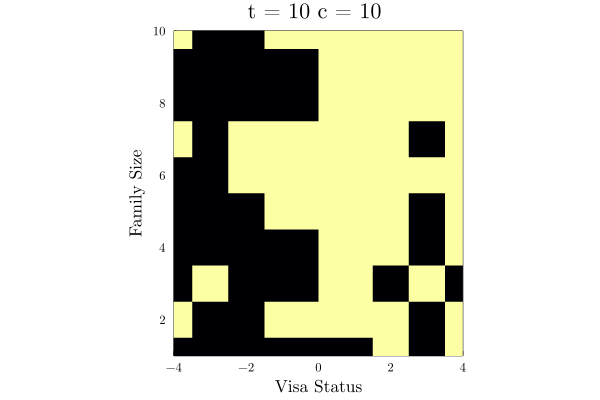

In [24]:
# full time and capacity 
p_1 = vis_time_step(policy, 10, 10)


In [50]:
# group plot 
# http://docs.juliaplots.org/latest/layouts/
function vis_all(policy)
    total_time = params.time 
    total_capacity = 60 #params.capacity
    total_graphs = total_time*total_capacity
    heat_maps = []
    time_points = total_time/20 
    capacity_points = total_capacity/20 
    num_graphs = trunc(Int,((total_time*total_capacity/20^2)))

    
    for t in 1:total_time
        if t % 20 == 0 
            for c in 1:total_capacity
                if c % 20 == 0
                push!(heat_maps, vis_time_step(policy, c, t))
                end
            end
        end
    end 
    plot(heat_maps..., layout=num_graphs)
end



#plot(p_1, p_2, layout = 2)


vis_all (generic function with 1 method)

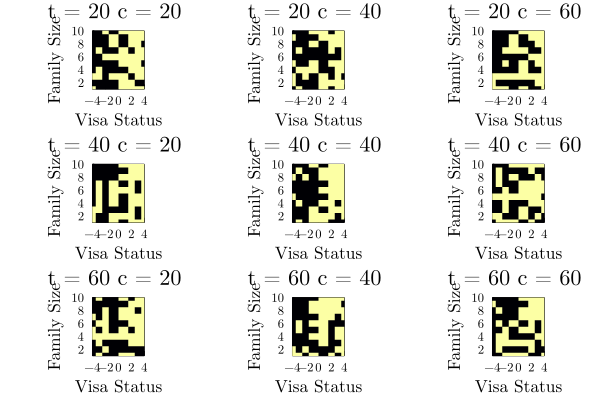

In [51]:
vis_all(policy)

In [26]:
60 % 20 == 0

true

In [ ]:
plot("$heat_maps[i]," for i in 1:2, layout=2)

In [ ]:
total_time

In [ ]:
rand(10, 4)

In [ ]:
gr(leg = false, bg = :lightgrey)

In [ ]:
plot(p1, p2)

In [ ]:
l = @layout [a b;  c d]
p1 = plot(vis_time_step(policy, 1, 0))
p2 = plot(vis_time_step(policy, 0, 1))
p3 = plot(vis_time_step(policy, 1, 1))
p4 = plot(vis_time_step(policy, 1, 1))
plot(p1, p2, p3, p4, layout = l)

In [ ]:
vis_all(policy)

In [ ]:
l = @layout [
    a{0.2w} [grid(2,2)
             b{0.2h}  ]
]

In [ ]:
vis_all(policy)

In [ ]:
#@show size(heat_maps) [shouldn't this be 60*20 here]

In [ ]:
p = vis(policy, 20, 20)
# plot(p)
#policyGraph = zeros(5,3) #turns into 5 by 3 matrix
#(xmax, ymax) = params.size    


In [ ]:
p = vis(policy, 20, 60)
#State(c, t, f, v)

In [ ]:
p = vis(policy, 10, 10)


**Visualizations**

In [ ]:
# struct evacPolicy <: Policy end 

In [ ]:
# function plot_evac(mdp::MDP,
#         policy::Policy=NothingPolicy(),  # our policy will have states State(c, t, f, v) with actions (reject/accept)
#         iter=0,
#         discount=NaN; 
#         outline=true,
#         show_policy=true,
#         show_rewards=false, 
#         outline_state::Union{State, Nothing}=nothing
#     )
                   
#     gr()
    
#     # what do here? 
# #     if policy isa NothingPolicy
# #         # override when the policy is empty
# #         show_policy = false
# #     end
    
#     show_policy = false
    
# #     U = zeros(1, params.size[1]*params.size[2]) # tryung 
# #     policy = ones(1, params.size[1]*params.size[2]) # how do you make a policy? 
# #    DISCUSS 
#     if iter == 0
#         # solver has not been run yet, so we just plot the raw rewards
#         # overwrite policy at time=0 to be emp
#         U = get_rewards(mdp, policy)
#     else
#         # otherwise, use the Value Function to get the values (i.e., utility)
#         U = values(mdp, policy)
#     end
    
#     # reshape to grid
#     (xmax, ymax) = params.size # reshape grid to family size * visa status
#     Uxy = reshape(U, xmax, ymax)
#     # plot values (i.e the U matrix)
#     fig = heatmap(Uxy',
#                   legend=:none,
#                   aspect_ratio=:equal,
#                   framestyle=:box,
#                   tickdirection=:out)
#     xlims!(0.5, xmax+0.5)
#     ylims!(0.5, ymax+0.5)
#     xticks!(1:xmax)
#     yticks!(1:ymax)
#     rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
#     # not sure the visualization makes perfect sense since x and y will not have every possible family size...
#     # policy_grid(policy::Policy, xmax::Int, ymax::Int, time::Int, capacity::Int)
#     # Let x represent family size, y represent visa status 
#     for x in 1:xmax, y in 1:ymax 
#         policy_grid(policy, xmax, ymax, 0, 0) # time = 0 and capacity = 0 here - the last time step 
#         annotate!([(x, y, (grid[x,y], :center, 12, "Computer Modern"))])
#         rect = rectangle(1, 1, x - 0.5, y - 0.5)
#         plot!(rect, fillalpha=0, linecolor=:gray)
        
#         # Some if statement here to say: 
#         # if policy at State(c,t,f,v) == ACCEPT
#             # color = green
#         # else 
#             # no color 
#     end
#         title!("Evacuation Policy Plot$extra_title")
#         return fig 
# end

In [ ]:
# plot_evac(mdp)

In [ ]:
# policy
# act = action(policy, State(0,0,1,5))


In [ ]:
# # create policy grid showing the best action in each state at a particular time and capacity 
# #State(c, t, f, v)
# function policy_grid(policy::Policy, xmax::Int, ymax::Int, time::Int, capacity::Int)
#     viz_action = Dict(REJECT => "",
#                   ACCEPT => "+",)
#     grid = Array{String}(undef, xmax, ymax)
#     for x = 1:xmax, y = 1:xmax
#         s = State(capacity, time, x, y) # x is family size, v is visa status 
#         grid[x,y] = viz_action[action(policy, s)] # need to define this action space 
#     end
#     return grid
# end


In [ ]:
#(chairs, time, family_size, visa_status)
#T(State(-1, -1, 4, 5), ACCEPT)
# this is the problem 
# ACCEPT: State(50, 9, ANYTHING, ANYTHING)
# ACCEPT: State(42, 9, ANYTHING, ANYTHING)
# REJECT: State(50, 9, ANYTHING, ANYTHING)

In [ ]:
# T(State(4, 3, 4, 5), ACCEPT)


In [ ]:
#T(State(-1, -1, 4, 5), ACCEPT)